# Reconstructing out-of-sample DVs

Given a quantitative ontology, or psychological space, that DVs can be projected into, how can we deterine the embedding of new variables?

Currently, our embedding is determined by factor analysis. Thus ontological embedding are only known for the DVs entered into the original model. How could we extend this?

One possibility is measuring new variables in the same population that completed our original battery. After doing this we could either (1) run the model anew, or (2) use linear regression to map the already discovered factors onto the new variables. The former is better, but results in small changes to the actual factors with each new variable. The latter method ensures that our factors stay the same. Neither is scalable, however, as we do not, in general, have access to a constant population that can be remeasured whenever new measures come into the picture.

Another possibility that works with new populations requires that the new population completes the entire battery used to estimate the original factors, in addition to whatever new variables are of interest. Doing so allows the calculation of factor scores for this new population based on the original model, which can then be mapped to the new measures of interest. This allows researchers to capitalize on the original model (presumably fit on more subjects than the new study), while expanding the ontology. Problems exist here, however.
- The most obvious problem is that you have to measure the new sample on the entire battery used to fit the original EFA model. Given that this takes many hours (the exact number depending on whether tasks, surveys or both are used), this is exceedingly impractical. In our cas we did have our new fMRI sample take the entire battery (or at least a subset of participants), so this problem isn't as relevant
- Still problems remain. If N is small, the estimate of the ontological embedding for new DVs is likely unstable.

This latter problem necessitates some quantitative exploration. This notebook simulates the issue by:
1. Removing a DV from the original ontology dataset
2. Performing EFA on this subset
3. Using linear regression to map these EFA factors to the left out variable

(3) is performed on smaller population sizes to reflect the reality of most studies (including ours) and is repeated to get a sense of the mapping's variability

### Small issues not currently addressed

- The EFA model is fit on the entire population. An even more stringent simulation would subset the subjects used in the "new study" and fit the EFA model on a completely independent group. I tried this once - the factor scores hardly differed. In addition, I want the EFA model to be as well-powered as possible, as that will be the reality for this method moving forward
- I am currently not holding out entire tasks, but only specific DVs

In [105]:
import argparse
import numpy as np
from os import makedirs, path
import pandas as pd
import pickle
from sklearn.linear_model import LinearRegression, Ridge

from dimensional_structure.reconstruction_utils import get_reconstruction_results, k_nearest_ontology_reconstruction
from selfregulation.utils.plot_utils import format_num
from selfregulation.utils.result_utils import load_results
from selfregulation.utils.utils import get_recent_dataset, get_info, get_retest_data

In [2]:
# argparse
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('-pop_sizes', nargs='+', default=[50, 100, 400], type=int)
    parser.add_argument('-n_reps', default=500)
    parser.add_argument('-n_measures', default=None, type=int)
    parser.add_argument('-dataset', default=None)
    parser.add_argument('-rerun', default=False)
    args, _ = parser.parse_known_args()
    pop_sizes = args.pop_sizes
    n_reps = args.n_reps
    n_measures = args.n_measures
    rerun = args.rerun
    if args.dataset is not None:
        dataset = args.dataset
    else:
        dataset = get_recent_dataset()

In [3]:
# additional setup
np.random.seed(12412)
results = load_results(dataset)['task']
retest_data = get_retest_data(dataset.replace('Complete', 'Retest'))
c = results.EFA.results['num_factors']

classifiers = {'Ridge': Ridge(fit_intercept=False),
               'LR': LinearRegression(fit_intercept=False)}
# get output dir to store results
output_dir = path.join(get_info('results_directory'),
                       'ontology_reconstruction', results.ID)
makedirs(output_dir, exist_ok=True)

/media/Data/Ian/miniconda/envs/SRO/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2862: DtypeWarning: Columns (1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [203]:
# get a random subset of variables to perform the calculation on if n_vars is set
measures = np.unique(['^'+i.split('.')[0] for i in results.data.columns])
if n_measures is not None:
    measure_list = np.random.choice(tasks, n_measures, replace=False)
else:
    measure_list = measures
# get all variables from selected tasks
var_list = results.data.filter(regex='|'.join(measure_list)).columns

Run simulation for every variable at different population sizes. 

That is, do the following:

1. take a variable (say stroop incongruent-congruent RT), remove it from the data matrix
2. Run EFA on the data matrix composes of the 522 (subject) x N-1 (variable) data matrix
3. Calculate factor scores for all 522 subjects
4. Select a subset of "pop_size" to do an "ontological mapping". That is, pretend that these subjects did the whole battery (missing the one variable) *and then* completed one more task. The idea is we want to do a mapping from those subject's factor scores to the new variable
   1. We can do a linear mapping (regression) from the ontological scores to the output variable
   2. We can do a k-nearest neighbor interpolation, where we say the unknown ontological factor is a blend of the "nearest" variables in the dataset
5. Repeat (4) a number of times to get a sense for the accuracy and variability of that mapping
6. Compare the estimated ontological scores for the held out var (stroop incongruent-congruent) to the original "correct" ontological mapping (that would have been obtained if the variable was included in the original data matrix

In [7]:
filename = path.join(output_dir, 'kreconstruct.pkl')
if not path.exists(filename) or rerun:
    k_reconstruction=get_reconstruction_results(results, measure_list, pop_sizes, n_reps=n_reps, 
                                                   fun=k_nearest_ontology_reconstruction, k_list=range(1,10))
    k_reconstruction.to_pickle(filename)
else:
    k_reconstruction = pd.read_pickle(filename)

In [113]:
summary = k_reconstruction.query('label=="partial_reconstruct"') \
                .groupby(['pop_size', 'k', 'weighted']).agg([np.mean, np.std])[['score-MSE', 'score-corr']]

In [44]:
# summarize further
k_best_params = {}
for pop_size in pop_sizes:
    tmp=summary.query('pop_size == %s' % pop_size)
    best_params = tmp.loc[:,'score-corr']['mean'].idxmax()
    best_val = tmp.loc[best_params,'score-corr']['mean']
    k_best_params[pop_size] = {'k': best_params[1], 
                               'weighted': bool(best_params[2]),
                               'best_val': best_val}

In [116]:
k_best_reconstruction = pd.DataFrame()
for k, v in k_best_params.items():
    tmp = k_reconstruction.query('pop_size == %s and \
                                 k == %s and \
                                 weighted == %s' % (k, v['k'], v['weighted']))
    k_best_reconstruction = pd.concat([k_best_reconstruction, tmp], axis=0)
k_best_reconstruction.groupby('pop_size')['score-corr'].agg(['mean','std'])

,mean,std
pop_size,,
50,0.682153,0.372700
100,0.758769,0.324452
400,0.839864,0.267563


In [ ]:
linear_reconstructions = {}
for name, clf in classifiers.items():
    for robust in [True, False]:
        out=get_reconstruction_results(results, measure_list, pop_sizes, n_reps=n_reps, clf=clf, robust=robust)
        filename = path.join(output_dir, 'linearreconstruct_clf-%s_robust-%s.pkl' % (name, str(robust)))
        out.to_pickle(filename)
        robust_str = '_robust' if robust else ''
        linear_reconstructions['%s%s' % (name, robust_str)] = out

In [ ]:
# summarize further
for name, reconstruction_df in linear_reconstructions.items():
    print(name)
    print(reconstruction_df.query('label=="partial_reconstruct"') \
            .groupby(['pop_size']).agg([np.mean, np.std])[['score-MSE', 'score-corr']])
    print('')

## Visualization

Of concern is the average correspondence and variability between the estimated ontological fingerprint of a DV and its "ground-truth" (the original estimate when it was part of the EFA model)

One way to look at this is just the average reconstruction score (e.g., for example) and variability of reconstruction score as a function of pseudo-pop-size and model parameters

In [46]:
# import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import MDS, TSNE
from scipy.spatial.distance import pdist, squareform

### K Nearest Visualization

#### Average Performance by Model Parameters

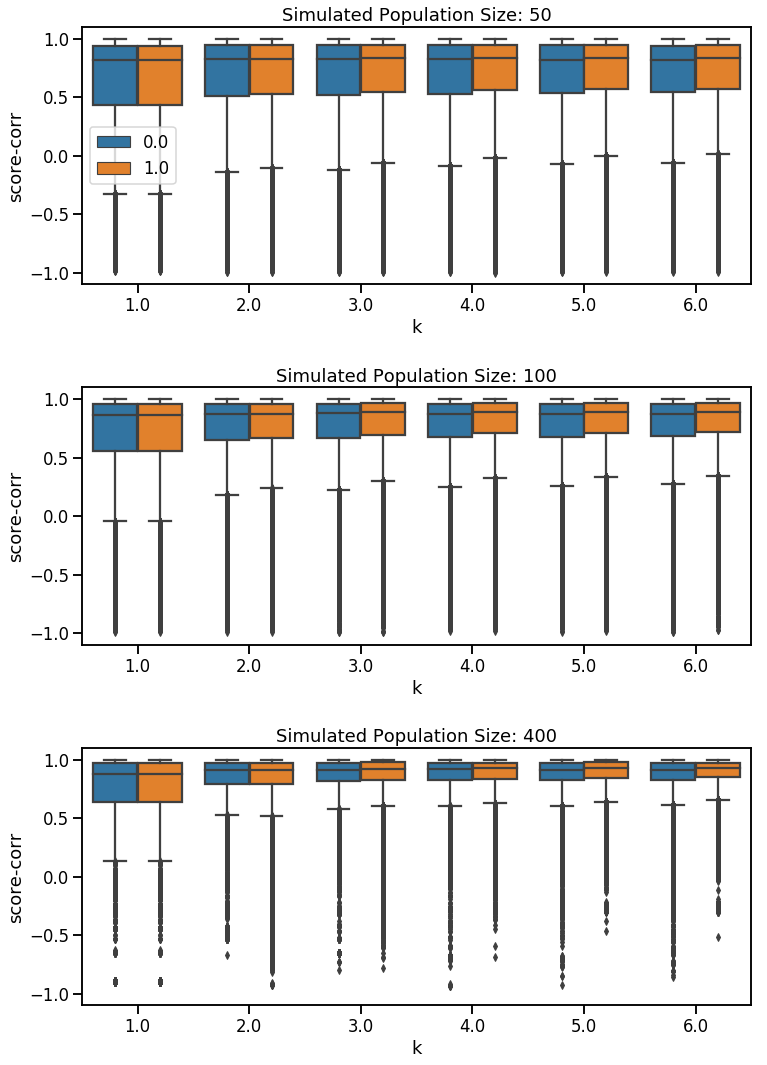

In [49]:
sns.set_context('talk')
n_cols = 1
n_rows = len(pop_sizes)//n_cols
f, axes = plt.subplots(n_rows, n_cols, figsize=(12,n_rows*6))
axes = f.get_axes()
legend_on=True
for ax, pop_size in zip(axes, pop_sizes):
    sns.boxplot(x='k', y='score-corr', hue='weighted', 
                data=k_reconstruction.query('pop_size==%s' % pop_size),
                ax=ax)
    ax.set_title('Simulated Population Size: %s' % pop_size)
    ax.set_ylim(-1.1,1.1)
    ax.legend().set_visible(legend_on)
    legend_on=False
plt.subplots_adjust(hspace=.4)

#### Performance for each DV by reliability

Only taking the best parameters from the k-nearest neighbor algorithm

/media/Data/Ian/miniconda/envs/SRO/lib/python3.5/site-packages/pandas/core/indexing.py:1027: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/media/Data/Ian/miniconda/envs/SRO/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


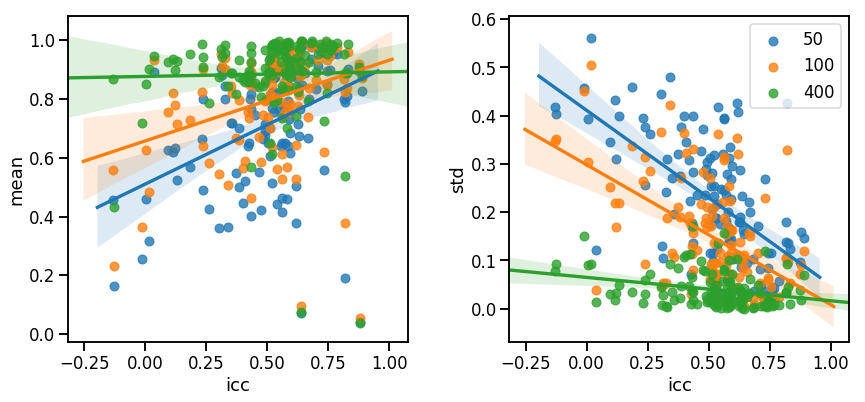

In [94]:
sns.set_context('talk')
f, axes = plt.subplots(1,2,figsize=(14,6))
colors = sns.color_palette(n_colors = len(pop_sizes))
for i, pop_size in enumerate(pop_sizes):
    reconstruction = k_best_reconstruction.query('pop_size == %s' % pop_size) \
                                     .groupby('var')['score-corr'].agg(['mean','std'])
    retest_vals = retest_data.loc[reconstruction.index,'icc']
    sns.regplot(retest_vals, reconstruction['mean'], 'o', label=pop_size, ax=axes[0], color=colors[i])
    sns.regplot(retest_vals, reconstruction['std'], 'o', label=pop_size, ax=axes[1], color=colors[i])
axes[1].legend()
plt.subplots_adjust(wspace=.3)

We can dive in and look at one high/mediun/low reliable variable to see the reconstruction performance

In [75]:
sorted_retest_vals = retest_vals.sort_values().index
high_var = sorted_retest_vals[-10]
med_var = sorted_retest_vals[50]
low_var = sorted_retest_vals[10]

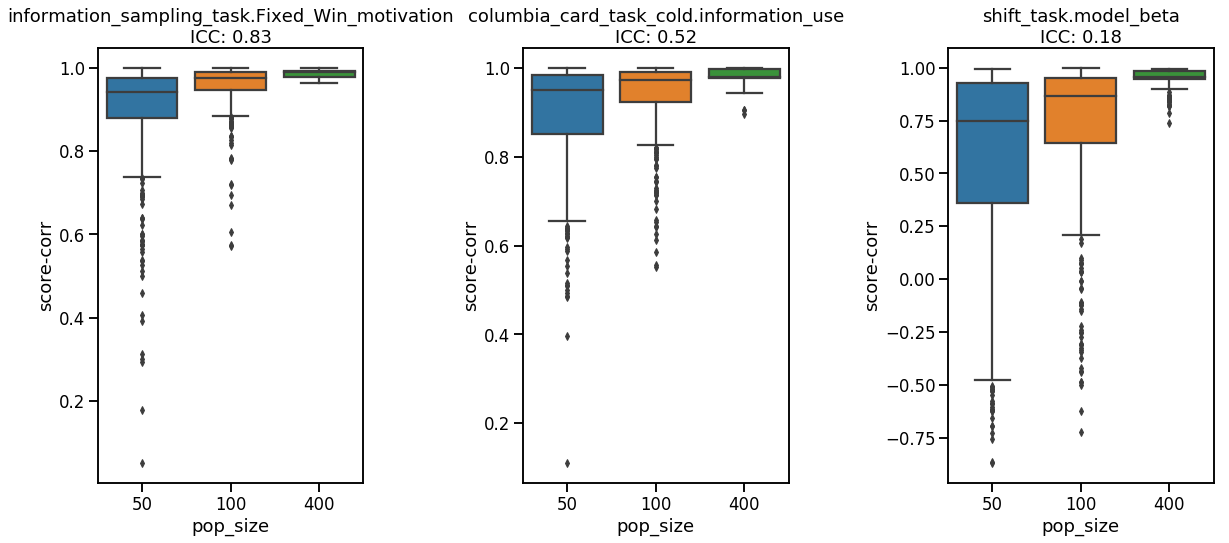

In [111]:
f, axes = plt.subplots(1,3, figsize=(20,8))
for ax, var in zip(axes, [high_var, med_var, low_var]):
    reliability = format_num(retest_data.loc[var]['icc'])
    plot_df = k_best_reconstruction.query('var == "%s" and label=="partial_reconstruct"' % var)
    sns.boxplot(x='pop_size', y='score-corr', data=plot_df,  ax=ax)
    ax.set_title('%s\nICC: %s' % (var, reliability))
plt.subplots_adjust(wspace=.6)

In [ ]:
sns.set_context('talk')
n_cols = 2
n_rows = (len(linear_reconstructions)+1)//n_cols
f, axes = plt.subplots(n_rows, n_cols, figsize=(10,10))
axes = f.get_axes()
for ax, (key, val) in zip(axes,linear_reconstructions.items()):
    plot_df = val.query('label=="partial_reconstruct"') \
                .groupby(['pop_size','var']) \
                .agg([np.mean, np.std])[['score-corr']].reset_index()
    plot_df.columns = [' '.join(col).strip() for col in plot_df.columns.values] # flatten hierarchical columns
    sns.boxplot(x='pop_size', y='score-corr mean', data=plot_df, ax=ax)
    sns.swarmplot(x='pop_size', y='score-corr mean', size=10, data=plot_df, ax=ax, edgecolors='black', linewidth=2)
    ax.set_title(key)
    ax.set_ylim(-.2, 1)
plt.subplots_adjust(hspace=.4, wspace=.4)

We see that with only 50 or 100 people the estimated ontological scores are pretty bad. With 400, they are pretty good, but still not perfect.

We can dive in and look at one variable to see the spread around the "true" value:

Text(0.5,1,'cognitive_reflection_survey.correct_proportion')

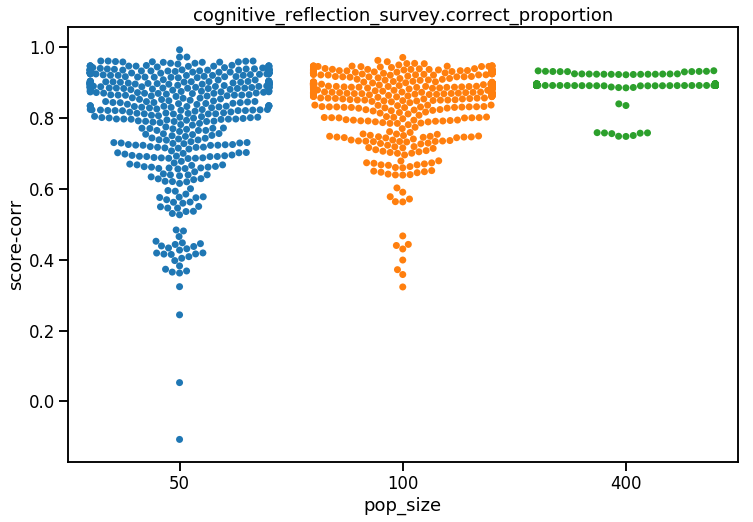

In [67]:
reconstruction_df = k_reconstruction.query('k==3 and weighted==True')
# make plot
var = np.random.choice(var_list)
plot_df = reconstruction_df.query('var == "%s"' % var)
plt.figure(figsize=(12,8))
sns.swarmplot(x='pop_size', y='score-corr', data=plot_df, size=7)
plt.title(var)

More complicate, we can visualize this by looking at the MDS plotting:
1. The original DVs
2. The "best" reconstruction using all the data
3. The n_reps simulated estimates with a smaller population size

In [ ]:
reconstruction_df.sort_values(by='label', inplace=True)

In [ ]:
# MDS
mds_reduced = []
tsne_reduced = []
for pop_size in pop_sizes:
    mds = MDS(2, dissimilarity='precomputed')
    tsne = TSNE(2, metric='precomputed')
    subset = reconstruction_df.query('pop_size == %s'% pop_size)
    reconstructions = subset.iloc[:, :c]
    distances = squareform(pdist(reconstructions, metric='correlation'))
    #mds_reduced.append(mds.fit_transform(distances)) # taking too long
    tsne_reduced.append(tsne.fit_transform(1-reconstructions.T.corr()))

In [ ]:
tmp_subset = reconstruction_df.query('pop_size == %s'% pop_sizes[-1])
base_colors = sns.color_palette(n_colors=len(var_list))
color_map = {var_list[i]:base_colors[i] for i in range(len(var_list))}
color_list = list(tmp_subset.loc[:,'var'].apply(lambda x: color_map[x]))
edge_colors = [color_list[i] if x=='partial_reconstruct' else [1,1,1] for i,x in enumerate(tmp_subset.label)]
size_list = [30 if x=='partial_reconstruct' else 200 for x in tmp_subset.label]

In [ ]:
N_pop = len(pop_sizes)
f,axes = plt.subplots(N_pop,1,figsize=(8,8*N_pop))
for ax, reduced, pop_size in zip(axes, tsne_reduced, pop_sizes):
    ax.scatter(reduced[:,0], reduced[:,1], c=color_list, s=size_list, edgecolors=edge_colors, linewidth=2)
    ax.set_title('Pseudo-Population Size: %s' % pop_size)